## Part 1 — Problem Understanding (Unique Domain)

### 1) Problem Domain (Unique + Practical)
We study a *streaming-catalog triage* problem for **international mid-/long-tail films**: many titles have incomplete metadata (missing revenue, missing runtime, missing taglines, inconsistent genres), but stakeholders still need to make operational decisions.

### 2) Research Goal
Build a data-driven workflow that helps a streaming platform team:
- **Classification:** identify titles likely to achieve **high audience engagement** (proxy: high `vote_count`).
- **Regression:** forecast **box-office revenue** (`revenue`) for planning and prioritization.

### 3) Why This Problem Matters
Streaming teams often decide which titles to acquire, translate, or promote under uncertainty. Predicting engagement and revenue supports cost-effective allocation of resources (marketing budget, localization, and content placement).

### 4) Target Variables
- **Classification target:** `high_engagement` (1 if `vote_count` is in the top quartile, else 0).
- **Regression target:** `revenue` (we also model `log_revenue = log1p(revenue)` to reduce skew).

## Part 2 — Data Collection

### Dataset Source (Public)
This dataset contains movie metadata commonly sourced from **The Movie Database (TMDb)**.  
A template recreation script is included as [download_dataset.py](download_dataset.py) (requires a TMDb API key, which is obtained from the public TMDb platform).

### Why This Dataset is Appropriate
- **Size:** 10,000+ rows (satisfies the ≥10,000 requirement)
- **Width:** 10+ columns (numerical + categorical + text)
- **Dirty:** missing values, inconsistent formatting (genre lists as strings), duplicates possible, outliers (revenue/popularity)
- **Real-world:** derived from real movie metadata used in industry contexts

# End-to-End Data Science & Machine Learning Project (Full Rebuild)

**Course Title:** Machine Learning  
**Section:** ________  

**Team Members**
- Mohamed Mostafa — 23101594
- Marwan Khaled — 23101599
- Mohamed Adel — 23101899

**Deliverables:** Clean notebook + PDF report + ZIP package  
**Dataset:** `Top_10000_Movies.csv` (10,000+ rows, 10+ columns, mixed data types, dirty)

**PDF Report Structure**
- Cover Page (Course Title: Machine Learning, Student Name, Section, ID)
- Section 1: Problem Domain
- Section 2: Project Summary
- Section 3: Source Code
- Section 4: Visualization Snapshots

## Part 1 — Problem Understanding

### Problem Domain (Unique + Applied)
This project models **streaming-catalog triage for international mid-/long-tail films**. The operational challenge is that many titles have incomplete, inconsistent, and noisy metadata (a common reality in content platforms).

### Research Goal
Build an end-to-end pipeline that supports two decision types:
1) **Classification:** predict whether a title will have **high audience engagement** (proxy by `vote_count`).
2) **Regression:** predict **financial performance** using `revenue` (box-office revenue proxy).

### Why It Matters
These predictions help prioritize which titles to acquire, market, localize, and recommend — especially for non-English catalogs where metadata quality may vary.

### Target Variables
- **Classification target:** `high_engagement` (1 if `vote_count` is in the top quartile, else 0).
- **Regression target:** `log_revenue = log1p(revenue)` (reduces skew; improves regression stability).

## Part 2 — Data Collection

### Dataset Source
The dataset is a real-world movie metadata extract typically derived from **The Movie Database (TMDb)** (public platform). A reproduction template is provided in `download_dataset.py` (requires an API key).

### Why this dataset is appropriate
- **Rows:** ≥ 10,000  
- **Columns:** ≥ 10  
- **Mixed types:** numeric (revenue, runtime, popularity) + categorical (language) + semi-structured (genre) + text (overview/tagline)  
- **Dirty:** missing values + inconsistent formatting + outliers + potential duplicates

In [1]:
# Cell 1 - Imports (standard libraries only)
from __future__ import annotations

from pathlib import Path
import ast
import re
import textwrap
import zipfile
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, median_absolute_error, r2_score,
    ConfusionMatrixDisplay, make_scorer,
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', 60)

In [3]:
# Cell 2 - Load dataset (robust path for Windows/VS Code)
import csv

PROJECT_DIR = Path.cwd().resolve()
CSV_NAME = 'Top_10000_Movies.csv'
data_path = PROJECT_DIR / CSV_NAME
if not data_path.exists():
    matches = list(PROJECT_DIR.rglob(CSV_NAME))
    if matches:
        data_path = matches[0]

print('Project directory:', PROJECT_DIR)
print('Dataset path:', data_path)
print('Exists:', data_path.exists())

try:
    df_raw = pd.read_csv(data_path)
except Exception as e:
    print('Default read_csv failed; retrying with python engine:', repr(e))
    # Some movie datasets contain very long text fields; increase csv field size limit.
    try:
        csv.field_size_limit(10**7)
    except Exception:
        pass
    df_raw = pd.read_csv(data_path, engine='python', on_bad_lines='warn')

print('Raw shape:', df_raw.shape)
df_raw.head()

Project directory: C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project
Dataset path: C:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\Top_10000_Movies.csv
Exists: True
Default read_csv failed; retrying with python engine: ParserError('Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.\n')
Raw shape: (10014, 13)


,Unnamed: 0,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline
0,0,580489.0,en,Venom: Let There Be Carnage,5401.308,2021-09-30,6.8,1736.0,"['Science Fiction', 'Action', 'Adventure']",After finding a host body in investigative rep...,424000000.0,97.0,NaN
1,1,524434.0,en,Eternals,3365.535,2021-11-03,7.1,622.0,"['Action', 'Adventure', 'Science Fiction', 'Fa...",The Eternals are a team of ancient aliens who ...,165000000.0,157.0,In the beginning...
2,2,438631.0,en,Dune,2911.423,2021-09-15,8.0,3632.0,"['Action', 'Adventure', 'Science Fiction']","Paul Atreides, a brilliant and gifted young ma...",331116356.0,155.0,"Beyond fear, destiny awaits."
3,3,796499.0,en,Army of Thieves,2552.437,2021-10-27,6.9,555.0,"['Action', 'Crime', 'Thriller']",A mysterious woman recruits bank teller Ludwig...,0.0,127.0,"Before Vegas, one locksmith became a legend."
4,4,550988.0,en,Free Guy,1850.470,2021-08-11,7.8,3493.0,"['Comedy', 'Action', 'Adventure', 'Science Fic...",A bank teller called Guy realizes he is a back...,331096766.0,115.0,Life's too short to be a background character.


In [4]:
# Cell 3 - Dataset dimensions + column dictionary
rows, cols = df_raw.shape
print('Rows:', rows)
print('Columns:', cols)

col_profile = pd.DataFrame({
    'column': df_raw.columns,
    'dtype': [str(t) for t in df_raw.dtypes],
    'missing_%': (df_raw.isna().mean() * 100).round(2).values,
    'sample_value': [df_raw[c].dropna().iloc[0] if df_raw[c].notna().any() else None for c in df_raw.columns],
})
col_profile

Rows: 10014
Columns: 13


,column,dtype,missing_%,sample_value
0,Unnamed: 0,object,0.00,0
1,id,float64,0.12,580489.0
2,original_language,object,0.12,en
3,original_title,object,0.13,Venom: Let There Be Carnage
4,popularity,float64,0.14,5401.308
5,release_date,object,0.52,2021-09-30
6,vote_average,float64,0.14,6.8
7,vote_count,float64,0.14,1736.0
8,genre,object,0.14,"['Science Fiction', 'Action', 'Adventure']"
9,overview,object,1.14,After finding a host body in investigative rep...


In [5]:
# Cell 4 - Confirm dataset is DIRTY (missing + duplicates + inconsistent genre formatting)
missing_top = (df_raw.isna().mean() * 100).sort_values(ascending=False)
display(missing_top.head(15))

dup_count = df_raw.duplicated(subset=['id']).sum() if 'id' in df_raw.columns else df_raw.duplicated().sum()
print('Duplicate rows (by id if available):', int(dup_count))

if 'genre' in df_raw.columns:
    print('Example genre values (stringified lists):')
    display(df_raw['genre'].dropna().astype(str).head(5))

tagline              29.308967
overview              1.138406
release_date          0.519273
runtime               0.249650
revenue               0.159776
popularity            0.139804
genre                 0.139804
vote_average          0.139804
vote_count            0.139804
original_title        0.129818
original_language     0.119832
id                    0.119832
Unnamed: 0            0.000000
dtype: float64

Duplicate rows (by id if available): 12
Example genre values (stringified lists):


0           ['Science Fiction', 'Action', 'Adventure']
1    ['Action', 'Adventure', 'Science Fiction', 'Fa...
2           ['Action', 'Adventure', 'Science Fiction']
3                      ['Action', 'Crime', 'Thriller']
4    ['Comedy', 'Action', 'Adventure', 'Science Fic...
Name: genre, dtype: object

## Part 3 — Data Cleaning & Refinement
We perform all required steps: missing values, missingness reasoning, remove irrelevant variables, duplicates, outliers (boxplots + IQR), scaling vs normalization, whitespace/formatting fixes, and consistent categories.

In [6]:
# Cell 5 - Standardize types, trim whitespace, fix inconsistent formats
df = df_raw.copy()

# Drop index-like columns
for c in list(df.columns):
    if c.lower().startswith('unnamed') or c.strip() == '':
        df = df.drop(columns=[c])

# Strip whitespace in object columns
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

# Normalize language casing
if 'original_language' in df.columns:
    df['original_language'] = df['original_language'].replace({'nan': np.nan}).str.lower()
    df['original_language'] = df['original_language'].fillna('unknown').replace({'': 'unknown'})

# Parse release_date -> year/decade
if 'release_date' in df.columns:
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['release_year'] = pd.to_numeric(df['release_date'].dt.year, errors='coerce')
    df['release_decade'] = (df['release_year'] // 10 * 10).astype('Int64')

# Convert numeric columns
for c in ['popularity', 'vote_average', 'vote_count', 'revenue', 'runtime', 'release_year']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Text columns -> fill + length features (keeps information without NLP libraries)
for c in ['overview', 'tagline', 'original_title']:
    if c in df.columns:
        df[c] = df[c].replace({'nan': ''}).fillna('').astype(str).str.strip()
        df[f'{c}_len'] = df[c].str.len()

df.shape

(10014, 17)

In [8]:
# Cell 6 - Fix inconsistent genre formatting and categories
def parse_genre_list(x: object) -> list[str]:
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s in {'', 'nan', 'None'}:
        return []
    try:
        lst = ast.literal_eval(s)
        if isinstance(lst, list):
            return [str(g).strip().title() for g in lst if str(g).strip() not in {'', 'nan'}]
        return []
    except Exception:
        # Fallback for messy strings
        s2 = re.sub(r"[\[\]\']", "", s)
        parts = [p.strip() for p in s2.split(',') if p.strip()]
        return [p.title() for p in parts]

if 'genre' in df.columns:
    df['genre_list'] = df['genre'].apply(parse_genre_list)
    df['genre_count'] = df['genre_list'].apply(len)
    df['genre_main'] = df['genre_list'].apply(lambda g: g[0] if len(g) else 'Unknown')

df[['genre', 'genre_main', 'genre_count']].head() if 'genre' in df.columns else 'No genre column'

,genre,genre_main,genre_count
0,"['Science Fiction', 'Action', 'Adventure']",Science Fiction,3
1,"['Action', 'Adventure', 'Science Fiction', 'Fa...",Action,4
2,"['Action', 'Adventure', 'Science Fiction']",Action,3
3,"['Action', 'Crime', 'Thriller']",Action,3
4,"['Comedy', 'Action', 'Adventure', 'Science Fic...",Comedy,4


In [9]:
# Cell 7 - Missing values and why they occur (data-driven)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
display(missing_pct.head(15))

# Interpretation (typical for movie metadata)
if 'revenue' in df.columns:
    revenue_zero_pct = (df['revenue'].fillna(0) == 0).mean() * 100
    print(f'Revenue == 0% (often undisclosed/missing): {revenue_zero_pct:.2f}%')

if 'runtime' in df.columns and 'release_decade' in df.columns:
    runtime_missing_by_decade = df.assign(runtime_missing=df['runtime'].isna()).groupby('release_decade')['runtime_missing'].mean().sort_index()
    display(runtime_missing_by_decade.tail(8))

release_year         0.519273
release_decade       0.519273
release_date         0.519273
runtime              0.249650
revenue              0.159776
vote_average         0.139804
vote_count           0.139804
popularity           0.139804
id                   0.119832
original_language    0.000000
original_title       0.000000
genre                0.000000
tagline              0.000000
overview             0.000000
overview_len         0.000000
dtype: float64

Revenue == 0% (often undisclosed/missing): 46.65%


release_decade
1950    0.000000
1960    0.000000
1970    0.012658
1980    0.003745
1990    0.000000
2000    0.000000
2010    0.001132
2020    0.000703
Name: runtime_missing, dtype: float64

In [10]:
# Cell 8 - Handle missing values (simple, transparent strategies)
# Categorical: fill 'unknown' / 'Unknown'
# Numeric: median imputation (robust to outliers)

for c in ['original_language', 'genre_main']:
    if c in df.columns:
        df[c] = df[c].replace({'nan': np.nan, '': np.nan}).fillna('unknown')

for c in ['popularity', 'vote_average', 'vote_count', 'runtime', 'release_year']:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())

# Revenue: keep as-is, but fill NaN with 0 (common convention; we also log-transform later)
if 'revenue' in df.columns:
    df['revenue'] = df['revenue'].fillna(0)

(df.isna().mean() * 100).sort_values(ascending=False).head(10)

release_decade       0.519273
release_date         0.519273
id                   0.119832
original_language    0.000000
popularity           0.000000
original_title       0.000000
vote_count           0.000000
vote_average         0.000000
overview             0.000000
revenue              0.000000
dtype: float64

In [11]:
# Cell 9 - Remove irrelevant variables (drop raw text + raw genre string)
drop_cols = [c for c in ['overview', 'tagline', 'original_title', 'genre'] if c in df.columns]
df2 = df.drop(columns=drop_cols).copy()
print('Dropped:', drop_cols)
df2.shape

Dropped: ['overview', 'tagline', 'original_title', 'genre']


(10014, 16)

In [12]:
# Cell 10 - Remove duplicates
before = len(df2)
if 'id' in df2.columns:
    df2 = df2.drop_duplicates(subset=['id'])
else:
    df2 = df2.drop_duplicates()
after = len(df2)
print('Before:', before)
print('After :', after)
print('Removed:', before - after)

Before: 10014
After : 10002
Removed: 12


### Outliers (Box Plots + IQR Removal)
We detect outliers with box plots and remove extreme values using the IQR method.

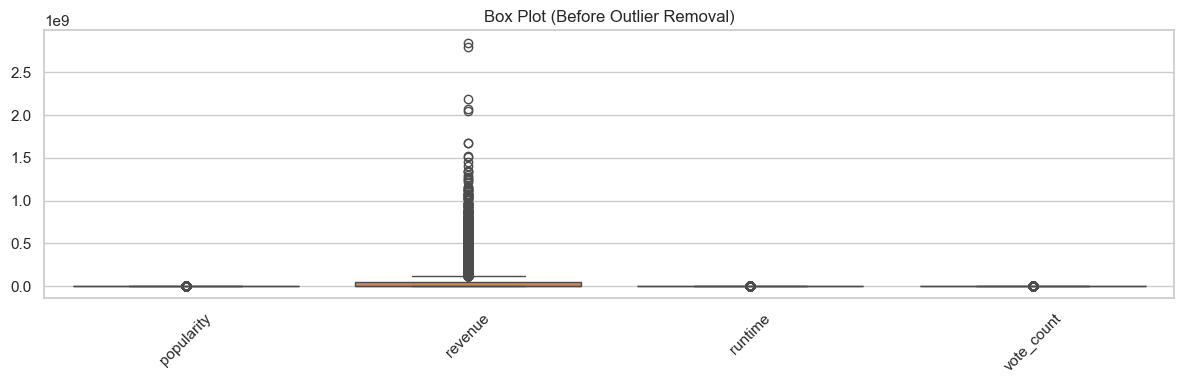

In [13]:
# Cell 11 - Box plot (before outlier removal)
outlier_cols = [c for c in ['popularity', 'revenue', 'runtime', 'vote_count'] if c in df2.columns]
plt.figure(figsize=(12, 4))
sns.boxplot(data=df2[outlier_cols])
plt.title('Box Plot (Before Outlier Removal)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Cell 12 - IQR outlier removal
def iqr_filter(df_in: pd.DataFrame, cols: list[str], k: float = 1.5):
    df_out = df_in.copy()
    mask = pd.Series(True, index=df_out.index)
    bounds = {}
    for c in cols:
        q1 = df_out[c].quantile(0.25)
        q3 = df_out[c].quantile(0.75)
        iqr = q3 - q1
        lo = q1 - k * iqr
        hi = q3 + k * iqr
        bounds[c] = (float(lo), float(hi))
        mask &= df_out[c].between(lo, hi)
    return df_out[mask].copy(), bounds

df_clean, outlier_bounds = iqr_filter(df2, outlier_cols, k=1.5)
print('Before:', df2.shape)
print('After :', df_clean.shape)
df_clean.head()

Before: (10002, 16)
After : (7068, 16)


,id,original_language,popularity,release_date,vote_average,vote_count,revenue,runtime,release_year,release_decade,overview_len,tagline_len,original_title_len,genre_list,genre_count,genre_main
767,761388.0,en,53.959,2021-09-17,6.8,22.0,0.0,96.0,2021.0,2020,119,23,17,"[Comedy, Fantasy]",2,Comedy
867,72431.0,en,55.302,2012-01-19,6.5,464.0,50365377.0,125.0,2012.0,2010,116,40,9,"[Drama, Action, Adventure, History, War]",5,Drama
884,291167.0,en,54.119,2014-08-12,4.4,15.0,0.0,88.0,2014.0,2010,327,31,14,"[Adventure, Science Fiction]",2,Adventure
892,347548.0,en,54.380,2015-07-09,5.9,133.0,0.0,77.0,2015.0,2010,190,46,11,"[Thriller, Horror, Science Fiction]",3,Thriller
915,9730.0,en,53.590,1984-04-13,6.1,889.0,32980880.0,91.0,1984.0,1980,184,60,34,[Horror],1,Horror


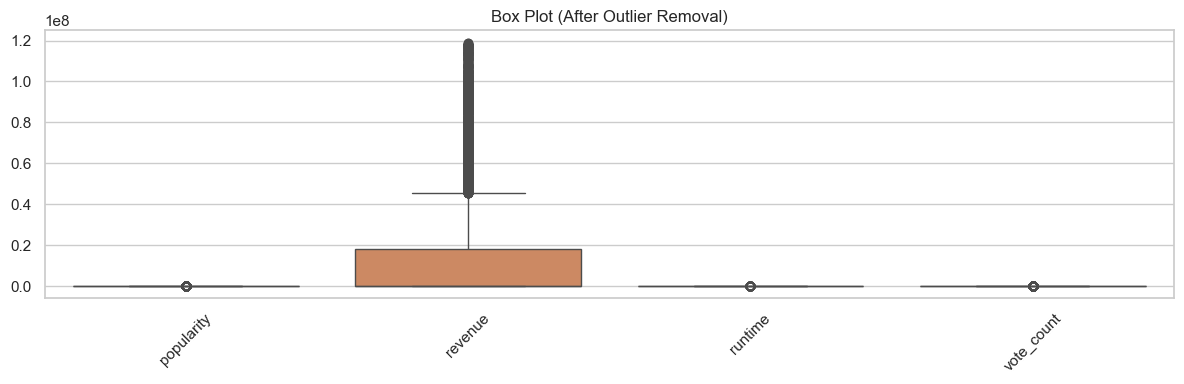

In [15]:
# Cell 13 - Box plot (after outlier removal)
plt.figure(figsize=(12, 4))
sns.boxplot(data=df_clean[outlier_cols])
plt.title('Box Plot (After Outlier Removal)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Part 4 — Exploratory Data Analysis (EDA)
We analyze trends, relationships, correlations, and perform segmentation.

In [17]:
# Cell 14 - Descriptive statistics
df_clean.describe(include='all').T.head(30)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,7067.0,NaN,NaN,NaN,244435.468799,0.0,13392.5,159638.0,443308.0,893304.0,247985.885639
original_language,7068,43,en,5385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
popularity,7068.0,NaN,NaN,NaN,17.723437,6.269,11.024,14.609,21.087,56.147,9.508007
release_date,7063,NaN,NaN,NaN,2007-09-16 12:34:45.685969152,1920-02-27 00:00:00,2002-09-21 12:00:00,2013-02-08 00:00:00,2017-12-16 12:00:00,2022-01-27 00:00:00,NaN
vote_average,7068.0,NaN,NaN,NaN,6.276938,0.0,5.8,6.4,7.0,9.5,1.213211
vote_count,7068.0,NaN,NaN,NaN,562.964205,0.0,112.0,328.0,795.0,3053.0,628.099929
revenue,7068.0,NaN,NaN,NaN,14767955.680532,0.0,0.0,0.0,18144183.5,119000410.0,26389216.874033
runtime,7068.0,NaN,NaN,NaN,100.146859,53.0,90.0,98.0,110.0,149.0,15.852625
release_year,7068.0,NaN,NaN,NaN,2007.188172,1920.0,2002.0,2013.0,2017.0,2022.0,14.987357
release_decade,7063.0,<NA>,<NA>,<NA>,2002.481948,1920.0,2000.0,2010.0,2010.0,2020.0,15.144875


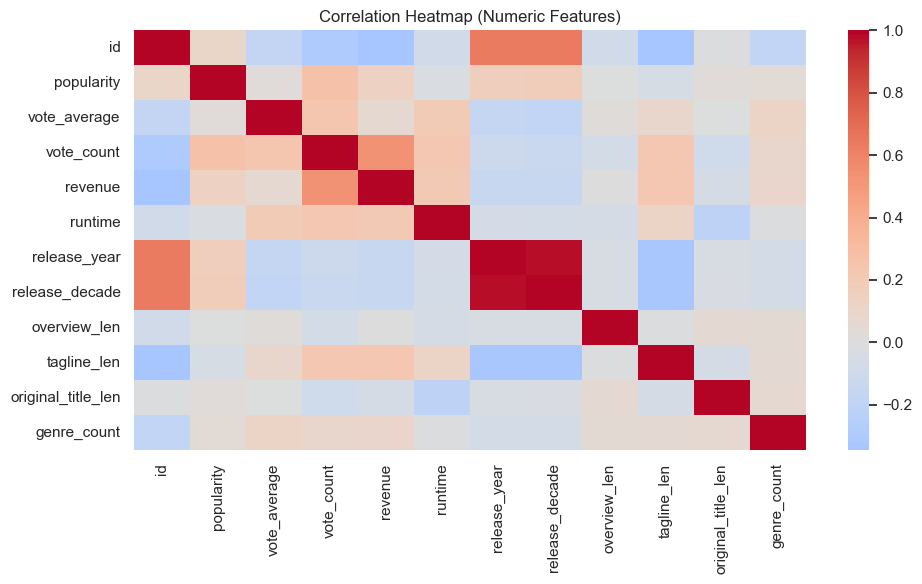

In [18]:
# Cell 15 - Correlation analysis
num_df = df_clean.select_dtypes(include=[np.number]).copy()
corr = num_df.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()

In [19]:
# Cell 16 - Segmentation (subset) by decade
if 'release_decade' in df_clean.columns:
    seg = df_clean.groupby('release_decade').agg({
        'popularity': 'mean' if 'popularity' in df_clean.columns else 'size',
        'revenue': 'median' if 'revenue' in df_clean.columns else 'size',
        'vote_count': 'median' if 'vote_count' in df_clean.columns else 'size',
    }).sort_index()
    display(seg.tail(10))
else:
    print('No release_decade available for segmentation.')

,popularity,revenue,vote_count
release_decade,,,
1930,12.285353,2000000.0,760.0
1940,11.816625,0.0,416.0
1950,12.238507,96568.0,437.0
1960,14.077048,0.0,490.0
1970,14.360176,1.5,401.0
1980,15.474772,16254729.5,479.5
1990,15.587389,11360912.5,458.5
2000,17.325200,10089373.0,512.0
2010,18.379485,0.0,286.0


## Part 5 — Data Visualization (All Required Plots)
We generate and interpret the required plots: line, area, histogram, bar, pie, box, scatter, bubble.

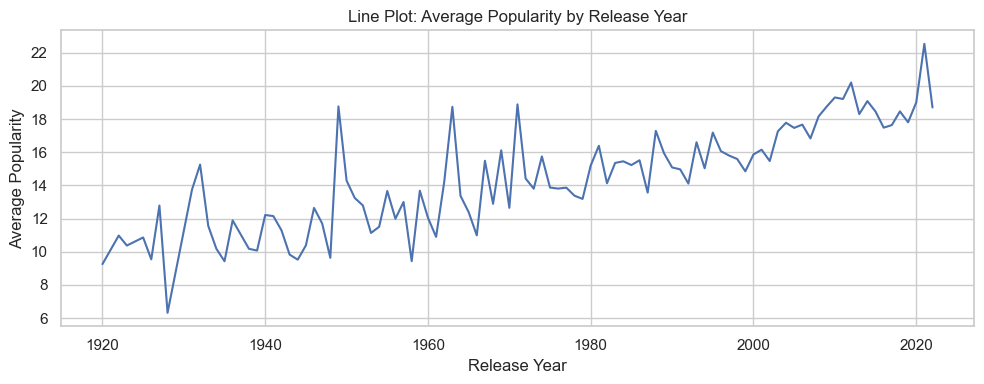

In [20]:
# Cell 17 - Line plot: average popularity by year
if {'release_year', 'popularity'}.issubset(df_clean.columns):
    tmp = df_clean.dropna(subset=['release_year']).groupby('release_year')['popularity'].mean().sort_index()
    plt.figure(figsize=(10, 4))
    plt.plot(tmp.index, tmp.values)
    plt.title('Line Plot: Average Popularity by Release Year')
    plt.xlabel('Release Year')
    plt.ylabel('Average Popularity')
    plt.tight_layout()
    plt.show()
else:
    print('Missing columns for line plot.')

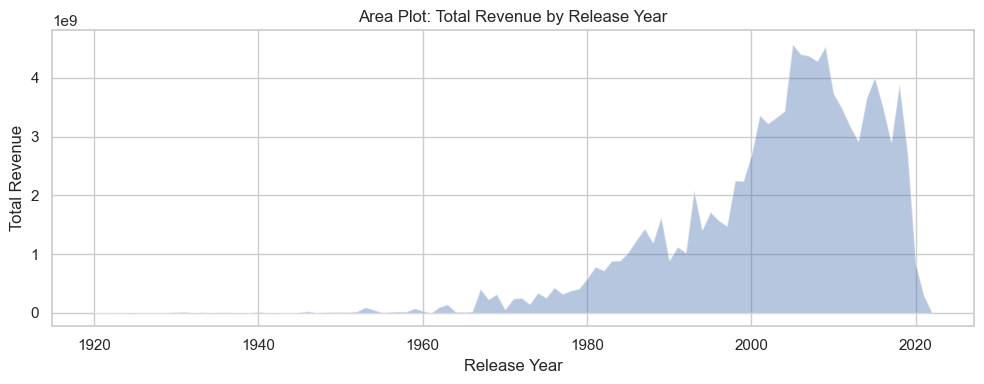

In [21]:
# Cell 18 - Area plot: total revenue by year
if {'release_year', 'revenue'}.issubset(df_clean.columns):
    tmp = df_clean.dropna(subset=['release_year']).groupby('release_year')['revenue'].sum().sort_index()
    plt.figure(figsize=(10, 4))
    plt.fill_between(tmp.index, tmp.values, alpha=0.4)
    plt.title('Area Plot: Total Revenue by Release Year')
    plt.xlabel('Release Year')
    plt.ylabel('Total Revenue')
    plt.tight_layout()
    plt.show()
else:
    print('Missing columns for area plot.')

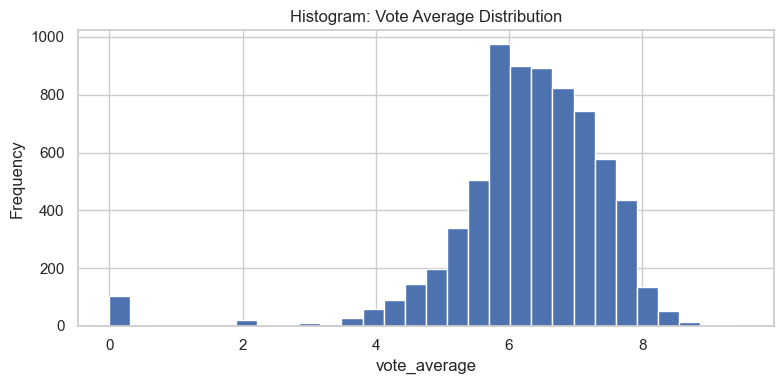

In [22]:
# Cell 19 - Histogram: vote_average distribution
if 'vote_average' in df_clean.columns:
    plt.figure(figsize=(8, 4))
    plt.hist(df_clean['vote_average'].dropna(), bins=30)
    plt.title('Histogram: Vote Average Distribution')
    plt.xlabel('vote_average')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print('vote_average column missing.')

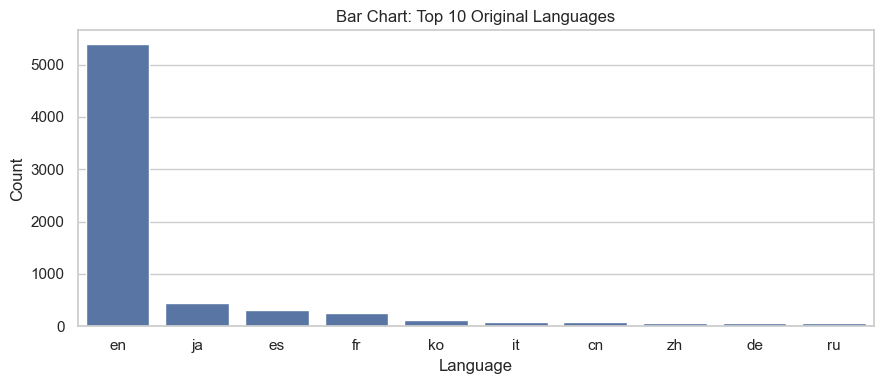

In [23]:
# Cell 20 - Bar chart: top languages
if 'original_language' in df_clean.columns:
    lang_counts = df_clean['original_language'].value_counts().head(10)
    plt.figure(figsize=(9, 4))
    sns.barplot(x=lang_counts.index, y=lang_counts.values)
    plt.title('Bar Chart: Top 10 Original Languages')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('original_language column missing.')

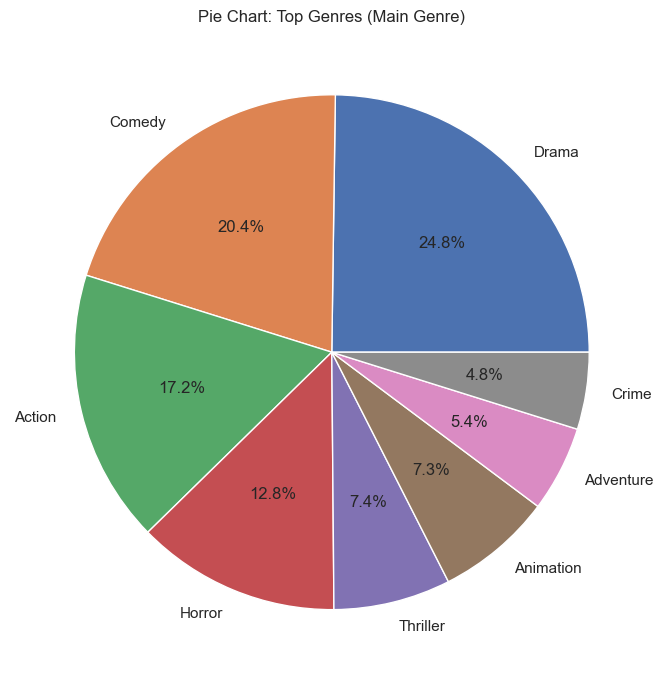

In [24]:
# Cell 21 - Pie chart: top genres
if 'genre_main' in df_clean.columns:
    genre_counts = df_clean['genre_main'].value_counts().head(8)
    plt.figure(figsize=(7, 7))
    plt.pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%')
    plt.title('Pie Chart: Top Genres (Main Genre)')
    plt.tight_layout()
    plt.show()
else:
    print('genre_main column missing.')

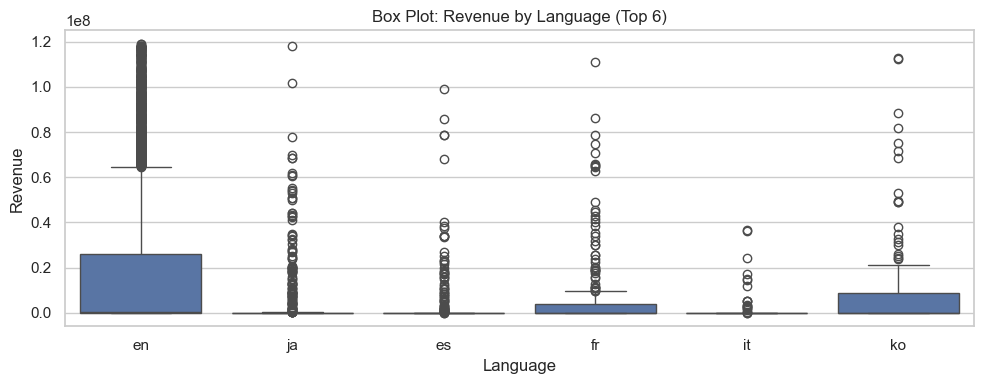

In [25]:
# Cell 22 - Box plot: revenue by language
if {'original_language', 'revenue'}.issubset(df_clean.columns):
    top_lang = df_clean['original_language'].value_counts().head(6).index
    tmp = df_clean[df_clean['original_language'].isin(top_lang)].copy()
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=tmp, x='original_language', y='revenue')
    plt.title('Box Plot: Revenue by Language (Top 6)')
    plt.xlabel('Language')
    plt.ylabel('Revenue')
    plt.tight_layout()
    plt.show()
else:
    print('Missing columns for box plot.')

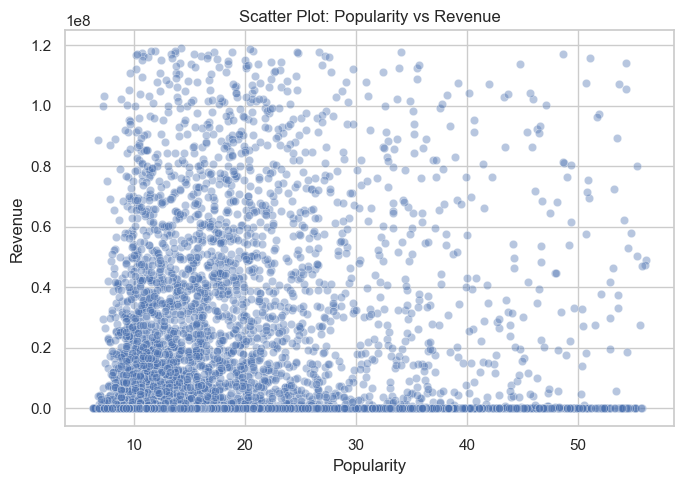

In [26]:
# Cell 23 - Scatter plot: popularity vs revenue
if {'popularity', 'revenue'}.issubset(df_clean.columns):
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=df_clean, x='popularity', y='revenue', alpha=0.4)
    plt.title('Scatter Plot: Popularity vs Revenue')
    plt.xlabel('Popularity')
    plt.ylabel('Revenue')
    plt.tight_layout()
    plt.show()
else:
    print('Missing columns for scatter plot.')

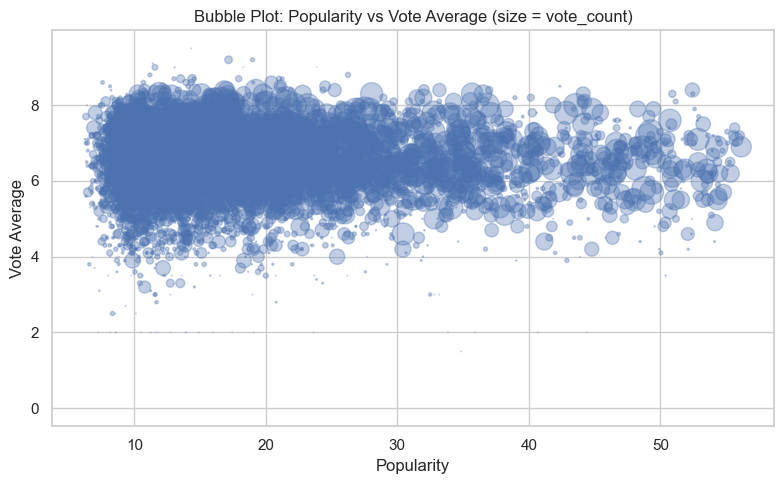

In [27]:
# Cell 24 - Bubble plot: popularity vs vote_average (size = vote_count)
need = {'popularity', 'vote_average', 'vote_count'}
if need.issubset(df_clean.columns):
    tmp = df_clean.dropna(subset=list(need)).copy()
    sizes = (tmp['vote_count'] / tmp['vote_count'].max()) * 300
    plt.figure(figsize=(8, 5))
    plt.scatter(tmp['popularity'], tmp['vote_average'], s=sizes, alpha=0.35)
    plt.title('Bubble Plot: Popularity vs Vote Average (size = vote_count)')
    plt.xlabel('Popularity')
    plt.ylabel('Vote Average')
    plt.tight_layout()
    plt.show()
else:
    print('Missing columns for bubble plot.')

## Part 6 — Machine Learning Models
We define inputs/outputs and train **at least 4 models** for each task, using models present in your original notebook: Logistic Regression, Random Forest, SVM, KNN. We also compare preprocessing modes (none vs scaling vs normalization).

In [28]:
# Cell 25 - Define targets and features
df_ml = df_clean.copy()

# Classification target: high_engagement (top quartile of vote_count)
q75 = df_ml['vote_count'].quantile(0.75)
df_ml['high_engagement'] = (df_ml['vote_count'] >= q75).astype(int)
print('high_engagement threshold (vote_count 75th percentile):', float(q75))
print(df_ml['high_engagement'].value_counts(normalize=True))

# Regression target: log revenue (reduces skew)
df_ml['log_revenue'] = np.log1p(df_ml['revenue'].clip(lower=0))

feature_candidates = [
    'original_language', 'genre_main',
    'popularity', 'vote_average', 'runtime', 'release_year',
    'overview_len', 'tagline_len', 'original_title_len',
    'genre_count',
]
features = [c for c in feature_candidates if c in df_ml.columns]
print('Features used:', features)

X = df_ml[features].copy()
y_clf = df_ml['high_engagement'].copy()
y_reg = df_ml['log_revenue'].copy()

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_clf, test_size=0.2, random_state=RANDOM_STATE, stratify=y_clf
)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

print('Train/Test (classification):', X_train_c.shape, X_test_c.shape)
print('Train/Test (regression)    :', X_train_r.shape, X_test_r.shape)

high_engagement threshold (vote_count 75th percentile): 795.0
high_engagement
0    0.749859
1    0.250141
Name: proportion, dtype: float64
Features used: ['original_language', 'genre_main', 'popularity', 'vote_average', 'runtime', 'release_year', 'overview_len', 'tagline_len', 'original_title_len', 'genre_count']
Train/Test (classification): (5654, 10) (1414, 10)
Train/Test (regression)    : (5654, 10) (1414, 10)


In [29]:
# Cell 26 - Preprocessing: ColumnTransformer (encoding + imputation + scaling/normalization)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print('Numeric columns:', num_cols)
print('Categorical columns:', cat_cols)

def make_preprocessor(mode: str) -> ColumnTransformer:
    if mode == 'standard':
        scaler = StandardScaler()
    elif mode == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = None

    num_steps = [('imputer', SimpleImputer(strategy='median'))]
    if scaler is not None:
        num_steps.append(('scaler', scaler))
    numeric_transformer = Pipeline(steps=num_steps)

    categorical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )

    return ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols),
        ]
    )

preprocessors = {
    'none': make_preprocessor('none'),
    'scaling_standard': make_preprocessor('standard'),
    'normalization_minmax': make_preprocessor('minmax'),
}
preprocessors

Numeric columns: ['popularity', 'vote_average', 'runtime', 'release_year', 'overview_len', 'tagline_len', 'original_title_len', 'genre_count']
Categorical columns: ['original_language', 'genre_main']


{'none': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median'))]),
                                  ['popularity', 'vote_average', 'runtime',
                                   'release_year', 'overview_len', 'tagline_len',
                                   'original_title_len', 'genre_count']),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehot',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['original_language', 'genre_main'])]),
 'scaling_standard': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                     

In [30]:
# Cell 27 - Classification: 4 models + cross-validation + comparison
clf_models = {
    'LogReg': LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    'RF': RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    'SVC': SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(n_neighbors=15),
}

cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring_clf = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'roc_auc': 'roc_auc',
}

rows = []
for mode_name, pre in preprocessors.items():
    for model_name, model in clf_models.items():
        pipe = Pipeline(steps=[('preprocess', pre), ('model', model)])
        cv = cross_validate(
            pipe,
            X_train_c,
            y_train_c,
            cv=cv_clf,
            scoring=scoring_clf,
            n_jobs=-1,
        )
        rows.append({
            'mode': mode_name,
            'model': model_name,
            'cv_accuracy': float(np.mean(cv['test_accuracy'])),
            'cv_precision': float(np.mean(cv['test_precision'])),
            'cv_recall': float(np.mean(cv['test_recall'])),
            'cv_roc_auc': float(np.mean(cv['test_roc_auc'])),
        })

clf_results = pd.DataFrame(rows).sort_values(['cv_roc_auc'], ascending=False)
clf_results

,mode,model,cv_accuracy,cv_precision,cv_recall,cv_roc_auc
5,scaling_standard,RF,0.825965,0.751660,0.452635,0.860952
1,none,RF,0.825434,0.749698,0.451921,0.860814
9,normalization_minmax,RF,0.826142,0.752519,0.452635,0.860761
4,scaling_standard,LogReg,0.785285,0.626959,0.351480,0.811525
8,normalization_minmax,LogReg,0.784754,0.640195,0.318951,0.811347
6,scaling_standard,SVC,0.780687,0.649002,0.271564,0.811237
10,normalization_minmax,SVC,0.774850,0.645325,0.227011,0.810834
0,none,LogReg,0.784401,0.627654,0.342999,0.810677
2,none,SVC,0.779978,0.611461,0.329557,0.804843
7,scaling_standard,KNN,0.792538,0.633649,0.401714,0.799951


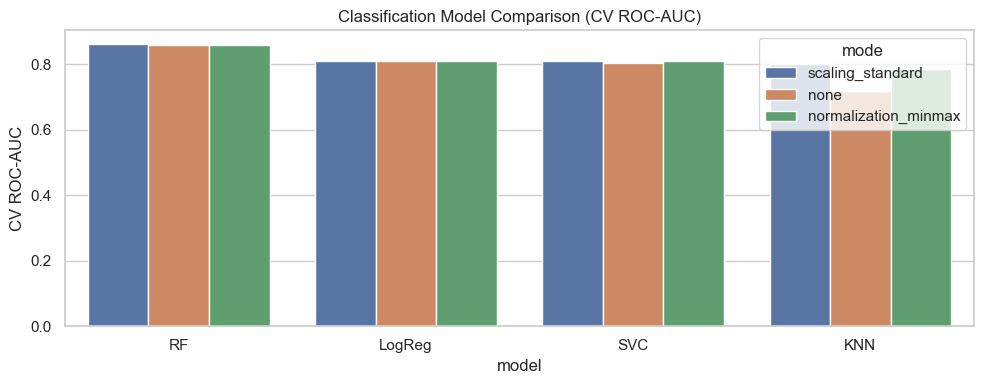

In [31]:
# Cell 28 - Classification comparison plot
plt.figure(figsize=(10, 4))
sns.barplot(data=clf_results, x='model', y='cv_roc_auc', hue='mode')
plt.title('Classification Model Comparison (CV ROC-AUC)')
plt.ylabel('CV ROC-AUC')
plt.tight_layout()
plt.show()

Best classifier: RF | preprocessing: scaling_standard
{'accuracy': 0.8323903818953324, 'precision': 0.7939698492462312, 'recall': 0.4463276836158192, 'roc_auc': 0.8855998827417119}


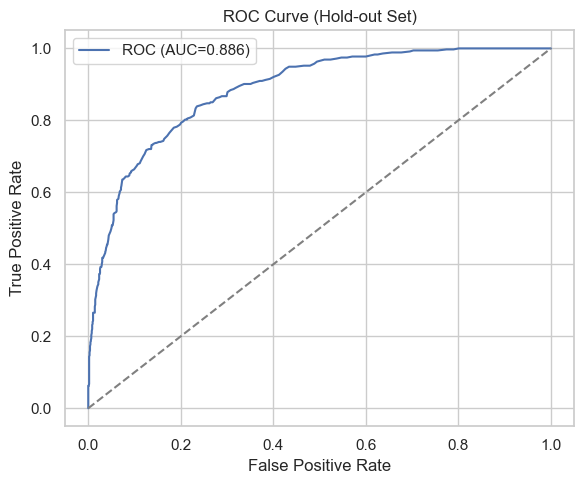

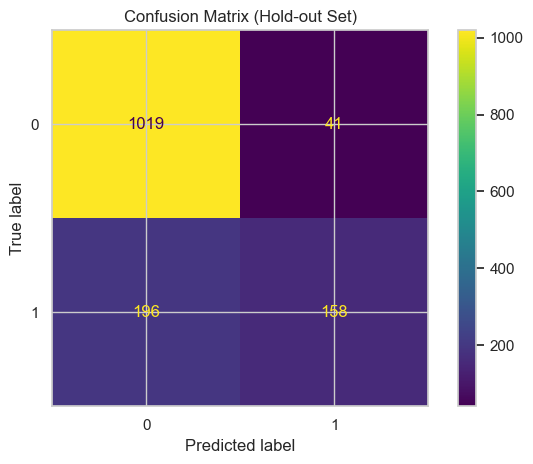

In [32]:
# Cell 29 - Classification hold-out evaluation + ROC curve
best = clf_results.iloc[0]
best_mode = best['mode']
best_model = best['model']
print('Best classifier:', best_model, '| preprocessing:', best_mode)

pipe = Pipeline(steps=[('preprocess', preprocessors[best_mode]), ('model', clf_models[best_model])])
pipe.fit(X_train_c, y_train_c)

y_proba = pipe.predict_proba(X_test_c)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

metrics = {
    'accuracy': accuracy_score(y_test_c, y_pred),
    'precision': precision_score(y_test_c, y_pred, zero_division=0),
    'recall': recall_score(y_test_c, y_pred, zero_division=0),
    'roc_auc': roc_auc_score(y_test_c, y_proba),
}
print(metrics)

fpr, tpr, _ = roc_curve(y_test_c, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC={metrics['roc_auc']:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve (Hold-out Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test_c, y_pred)
plt.title('Confusion Matrix (Hold-out Set)')
plt.tight_layout()
plt.show()

In [33]:
# Cell 30 - Regression: 4 models + cross-validation + comparison
reg_models = {
    'LinReg': LinearRegression(),
    'RFReg': RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    'SVR': SVR(kernel='linear'),
    'KNNReg': KNeighborsRegressor(n_neighbors=20),
}

cv_reg = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring_reg = {
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
    'medae': make_scorer(median_absolute_error, greater_is_better=False),
    'r2': 'r2',
}

rows = []
for mode_name, pre in preprocessors.items():
    for model_name, model in reg_models.items():
        pipe = Pipeline(steps=[('preprocess', pre), ('model', model)])
        cv = cross_validate(
            pipe,
            X_train_r,
            y_train_r,
            cv=cv_reg,
            scoring=scoring_reg,
            n_jobs=-1,
        )
        rows.append({
            'mode': mode_name,
            'model': model_name,
            'cv_mae': float(-np.mean(cv['test_mae'])),
            'cv_mse': float(-np.mean(cv['test_mse'])),
            'cv_medae': float(-np.mean(cv['test_medae'])),
            'cv_r2': float(np.mean(cv['test_r2'])),
        })

reg_results = pd.DataFrame(rows).sort_values(['cv_r2'], ascending=False)
reg_results

,mode,model,cv_mae,cv_mse,cv_medae,cv_r2
1,none,RFReg,5.486107,44.992758,4.676632,0.333972
9,normalization_minmax,RFReg,5.487023,45.014489,4.670375,0.333650
5,scaling_standard,RFReg,5.487546,45.019832,4.656371,0.333575
7,scaling_standard,KNNReg,6.126672,49.994711,5.655707,0.259936
11,normalization_minmax,KNNReg,6.217612,50.948876,5.763406,0.245831
0,none,LinReg,6.458095,52.394876,6.357860,0.224402
4,scaling_standard,LinReg,6.458008,52.400261,6.351473,0.224323
8,normalization_minmax,LinReg,6.458033,52.400442,6.351451,0.224320
3,none,KNNReg,6.415352,53.004072,5.964905,0.215359
2,none,SVR,6.315210,53.941776,5.978213,0.201427


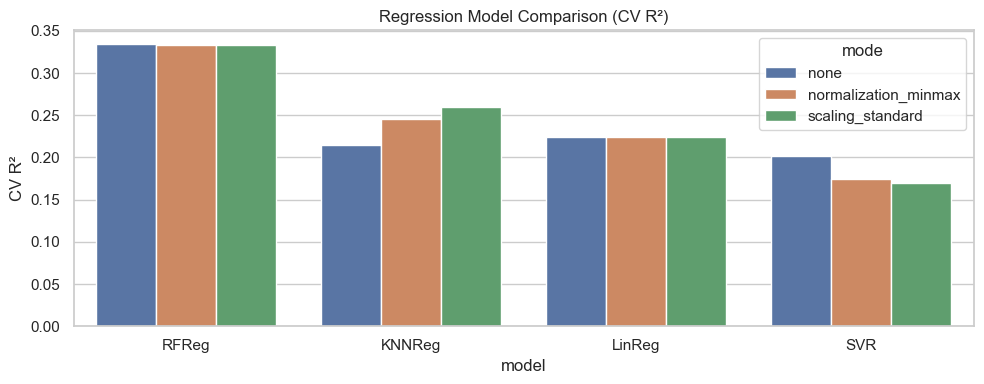

In [34]:
# Cell 31 - Regression comparison plot
plt.figure(figsize=(10, 4))
sns.barplot(data=reg_results, x='model', y='cv_r2', hue='mode')
plt.title('Regression Model Comparison (CV R²)')
plt.ylabel('CV R²')
plt.tight_layout()
plt.show()

In [35]:
# Cell 32 - Output paths for deliverables
OUT_DIR = Path.cwd() / 'redo_artifacts'
FIG_DIR = OUT_DIR / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)
REPORT_PATH = OUT_DIR / 'Final_Report_Redo.pdf'
ZIP_PATH = OUT_DIR / 'Submission_Package_Redo.zip'
print('Artifacts folder:', OUT_DIR)

Artifacts folder: c:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\redo_artifacts


In [36]:
# Cell 33 - Save key figures for the report/ZIP
def save_fig(path: Path):
    plt.savefig(path, dpi=200, bbox_inches='tight')
    plt.close()
    print('Saved:', path.name)

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
save_fig(FIG_DIR / '01_correlation_heatmap.png')

# Classification comparison
plt.figure(figsize=(10, 4))
sns.barplot(data=clf_results, x='model', y='cv_roc_auc', hue='mode')
plt.title('Classification Model Comparison (CV ROC-AUC)')
plt.tight_layout()
save_fig(FIG_DIR / '02_clf_comparison.png')

# Regression comparison
plt.figure(figsize=(10, 4))
sns.barplot(data=reg_results, x='model', y='cv_r2', hue='mode')
plt.title('Regression Model Comparison (CV R²)')
plt.tight_layout()
save_fig(FIG_DIR / '03_reg_comparison.png')

Saved: 01_correlation_heatmap.png
Saved: 02_clf_comparison.png
Saved: 03_reg_comparison.png


Report created: c:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\redo_artifacts\Final_Report_Redo.pdf
NOTE: If needed, update SECTION in this cell before submission.


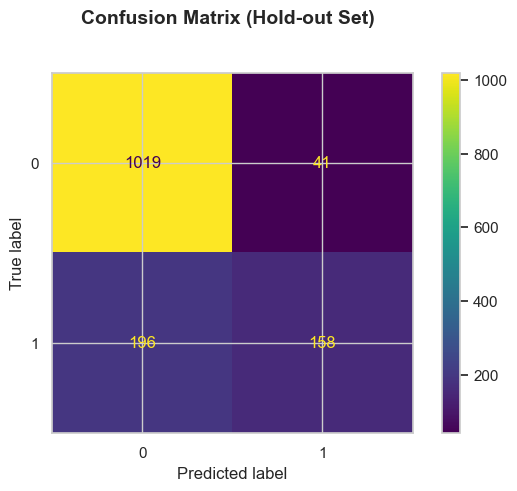

In [41]:
# Cell 34 - Generate PDF report (matplotlib PdfPages)
TEAM_MEMBERS = [
    {'name': 'Mohamed Mostafa', 'id': '23101594'},
    {'name': 'Marwan Khaled', 'id': '23101599'},
    {'name': 'Mohamed Adel', 'id': '23101899'},
]
SECTION = '________'
COURSE_TITLE = 'Machine Learning'

def add_text_page(pdf: PdfPages, title: str, lines: list[str]):
    fig = plt.figure(figsize=(8.27, 11.69))  # A4
    fig.patch.set_facecolor('white')
    plt.axis('off')
    y = 0.95
    plt.text(0.07, y, title, fontsize=18, fontweight='bold', va='top')
    y -= 0.06
    wrapped: list[str] = []
    for line in lines:
        wrapped.extend(textwrap.wrap(str(line), width=95) or [''])
    for line in wrapped:
        plt.text(0.07, y, line, fontsize=11, va='top')
        y -= 0.022
        if y < 0.08:
            break
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

def add_plot_page(pdf: PdfPages, title: str, plot_func):
    """Create a matplotlib figure via plot_func(ax/plt) and save it as a PDF page."""
    fig = plt.figure(figsize=(11, 6.5))
    try:
        plot_func()
        plt.suptitle(title, y=1.02, fontsize=14, fontweight='bold')
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
    finally:
        plt.close(fig)

cover_lines = [
    f'Course Title: {COURSE_TITLE}',
    f'Section: {SECTION}',
    '',
    'Student Name / ID:',
]
for m in TEAM_MEMBERS:
    cover_lines.append(f"- {m['name']} : {m['id']}")
cover_lines.append('')
cover_lines.append(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

# Helper: safe access to df used for plots
_df_plot = df_clean if 'df_clean' in globals() else (df if 'df' in globals() else None)
missing_notes: list[str] = []

with PdfPages(REPORT_PATH) as pdf:
    # Cover + required sections
    add_text_page(pdf, 'Cover Page', cover_lines)

    add_text_page(
        pdf,
        'Section 1: Problem Domain',
        [
            'Streaming-catalog triage for international mid-/long-tail films.',
            'Tasks: engagement classification + revenue regression.',
        ],
    )

    add_text_page(
        pdf,
        'Section 2: Project Summary',
        [
            f"Dataset rows/cols: {df_raw.shape[0]} / {df_raw.shape[1]}" if 'df_raw' in globals() else 'Dataset rows/cols: (not available in kernel)',
            'Cleaning: missing values, formatting fixes, duplicate removal, outlier removal (IQR).',
            'Models: Logistic Regression, Random Forest, SVM, KNN (classification + regression variants).',
            'Compared preprocessing: none vs StandardScaler vs MinMaxScaler.',
        ],
    )

    add_text_page(
        pdf,
        'Section 3: Source Code',
        [
            'Notebook: Ml_Project_Full_Rebuild.ipynb',
            'Dataset: Top_10000_Movies.csv',
            'Download template: download_dataset.py',
        ],
    )

    add_text_page(
        pdf,
        'Section 4: Visualization Snapshots',
        ['All graphs generated in the notebook are included in the following pages.'],
    )

    # ---- EDA plots (re-created and embedded) ----
    if _df_plot is None:
        missing_notes.append('Could not find df_clean/df in memory to regenerate EDA plots.')
    else:
        # 1) Line plot: Average Popularity by Release Year
        def _line_avg_popularity():
            if 'release_year' in _df_plot.columns and 'popularity' in _df_plot.columns:
                tmp = _df_plot.dropna(subset=['release_year']).groupby('release_year')['popularity'].mean()
                plt.plot(tmp.index, tmp.values)
                plt.xlabel('Release Year')
                plt.ylabel('Average Popularity')
            else:
                plt.text(0.1, 0.5, 'Missing columns for line plot.', fontsize=12)
                plt.axis('off')
        add_plot_page(pdf, 'Line Plot: Average Popularity by Release Year', _line_avg_popularity)

        # 2) Area plot: Total Revenue by Release Year
        def _area_total_revenue():
            if 'release_year' in _df_plot.columns and 'revenue' in _df_plot.columns:
                tmp = _df_plot.dropna(subset=['release_year']).groupby('release_year')['revenue'].sum()
                plt.fill_between(tmp.index, tmp.values, alpha=0.35)
                plt.xlabel('Release Year')
                plt.ylabel('Total Revenue')
            else:
                plt.text(0.1, 0.5, 'Missing columns for area plot.', fontsize=12)
                plt.axis('off')
        add_plot_page(pdf, 'Area Plot: Total Revenue by Release Year', _area_total_revenue)

        # 3) Histogram: Vote Average Distribution
        def _hist_vote_average():
            if 'vote_average' in _df_plot.columns:
                sns.histplot(_df_plot['vote_average'].dropna(), bins=20, kde=False)
                plt.xlabel('vote_average')
                plt.ylabel('Frequency')
            else:
                plt.text(0.1, 0.5, 'Missing column for histogram.', fontsize=12)
                plt.axis('off')
        add_plot_page(pdf, 'Histogram: Vote Average Distribution', _hist_vote_average)

        # 4) Bar chart: Top 10 Original Languages
        def _bar_top_languages():
            if 'original_language' in _df_plot.columns:
                lang_counts = _df_plot['original_language'].value_counts().head(10)
                sns.barplot(x=lang_counts.index, y=lang_counts.values)
                plt.xlabel('Language')
                plt.ylabel('Count')
            else:
                plt.text(0.1, 0.5, 'Missing column for bar chart.', fontsize=12)
                plt.axis('off')
        add_plot_page(pdf, 'Bar Chart: Top 10 Original Languages', _bar_top_languages)

        # 5) Pie chart: Top Genres (Main Genre)
        def _pie_top_genres():
            if 'genre_main' in _df_plot.columns:
                genre_counts = _df_plot['genre_main'].value_counts().head(8)
                plt.pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%', startangle=90)
                plt.axis('equal')
            else:
                plt.text(0.1, 0.5, 'Missing column for pie chart.', fontsize=12)
                plt.axis('off')
        add_plot_page(pdf, 'Pie Chart: Top Genres (Main Genre)', _pie_top_genres)

        # 6) Box plot: Revenue by Language (Top 6)
        def _box_revenue_by_language():
            if 'original_language' in _df_plot.columns and 'revenue' in _df_plot.columns:
                top_lang = _df_plot['original_language'].value_counts().head(6).index
                sns.boxplot(data=_df_plot[_df_plot['original_language'].isin(top_lang)], x='original_language', y='revenue')
                plt.xlabel('Language')
                plt.ylabel('Revenue')
            else:
                plt.text(0.1, 0.5, 'Missing columns for box plot.', fontsize=12)
                plt.axis('off')
        add_plot_page(pdf, 'Box Plot: Revenue by Language (Top 6)', _box_revenue_by_language)

        # 7) Scatter plot: Popularity vs Revenue
        def _scatter_pop_revenue():
            if 'popularity' in _df_plot.columns and 'revenue' in _df_plot.columns:
                plt.scatter(_df_plot['popularity'], _df_plot['revenue'], alpha=0.3)
                plt.xlabel('Popularity')
                plt.ylabel('Revenue')
            else:
                plt.text(0.1, 0.5, 'Missing columns for scatter plot.', fontsize=12)
                plt.axis('off')
        add_plot_page(pdf, 'Scatter Plot: Popularity vs Revenue', _scatter_pop_revenue)

        # 8) Bubble plot: Popularity vs Vote Average (size = vote_count)
        def _bubble_pop_voteavg():
            if {'popularity', 'vote_average', 'vote_count'}.issubset(_df_plot.columns):
                sizes = np.sqrt(_df_plot['vote_count'].clip(lower=0).fillna(0))
                plt.scatter(_df_plot['popularity'], _df_plot['vote_average'], s=sizes, alpha=0.25)
                plt.xlabel('Popularity')
                plt.ylabel('Vote Average')
            else:
                plt.text(0.1, 0.5, 'Missing columns for bubble plot.', fontsize=12)
                plt.axis('off')
        add_plot_page(pdf, 'Bubble Plot: Popularity vs Vote Average (size = vote_count)', _bubble_pop_voteavg)

    # ---- Model comparison plots (re-created and embedded) ----
    if 'corr' in globals() and isinstance(corr, pd.DataFrame):
        def _corr_heatmap():
            sns.heatmap(corr, cmap='coolwarm', center=0)
        add_plot_page(pdf, 'Correlation Heatmap (Numeric Features)', _corr_heatmap)
    else:
        missing_notes.append('Correlation heatmap not available (corr missing).')

    if 'clf_results' in globals() and isinstance(clf_results, pd.DataFrame):
        def _clf_comparison():
            sns.barplot(data=clf_results, x='model', y='cv_roc_auc', hue='mode')
            plt.ylabel('CV ROC-AUC')
        add_plot_page(pdf, 'Classification Model Comparison (CV ROC-AUC)', _clf_comparison)
    else:
        missing_notes.append('Classification comparison plot not available (clf_results missing).')

    if 'reg_results' in globals() and isinstance(reg_results, pd.DataFrame):
        def _reg_comparison():
            sns.barplot(data=reg_results, x='model', y='cv_r2', hue='mode')
            plt.ylabel('CV R²')
        add_plot_page(pdf, 'Regression Model Comparison (CV R²)', _reg_comparison)
    else:
        missing_notes.append('Regression comparison plot not available (reg_results missing).')

    # Hold-out ROC + Confusion Matrix if we still have predictions
    if {'fpr', 'tpr'}.issubset(globals()) and 'metrics' in globals() and isinstance(metrics, dict) and 'roc_auc' in metrics:
        def _roc_curve_page():
            plt.plot(fpr, tpr, label=f"ROC (AUC={metrics['roc_auc']:.3f})")
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
        add_plot_page(pdf, 'ROC Curve (Hold-out Set)', _roc_curve_page)
    else:
        missing_notes.append('ROC curve not available (fpr/tpr/metrics missing).')

    if 'y_test_c' in globals() and 'y_pred' in globals():
        def _cm_page():
            ConfusionMatrixDisplay.from_predictions(y_test_c, y_pred)
        add_plot_page(pdf, 'Confusion Matrix (Hold-out Set)', _cm_page)
    else:
        missing_notes.append('Confusion matrix not available (y_test_c/y_pred missing).')

    # Final notes page if anything was missing
    if missing_notes:
        add_text_page(pdf, 'Notes', ['Some plots could not be regenerated in this run:'] + [f"- {n}" for n in missing_notes])

print('Report created:', REPORT_PATH)
print('NOTE: If needed, update SECTION in this cell before submission.')

In [42]:
# Cell 35 - Create ZIP package (notebook + dataset + figures + report)
def add_to_zip(zipf: zipfile.ZipFile, path: Path, arc_prefix: str = ''):
    if path.is_dir():
        for p in path.rglob('*'):
            if p.is_file():
                zipf.write(p, arcname=str(Path(arc_prefix) / p.relative_to(path)))
    elif path.is_file():
        zipf.write(path, arcname=str(Path(arc_prefix) / path.name))

notebook_path = Path.cwd() / 'Ml_Project_Full_Rebuild.ipynb'
download_script = Path.cwd() / 'download_dataset.py'

with zipfile.ZipFile(ZIP_PATH, 'w', compression=zipfile.ZIP_DEFLATED) as z:
    add_to_zip(z, notebook_path, arc_prefix='source')
    if download_script.exists():
        add_to_zip(z, download_script, arc_prefix='source')
    add_to_zip(z, data_path, arc_prefix='data')
    add_to_zip(z, FIG_DIR, arc_prefix='figures')
    add_to_zip(z, REPORT_PATH, arc_prefix='report')

print('ZIP created:', ZIP_PATH)

ZIP created: c:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\redo_artifacts\Submission_Package_Redo.zip
